# 0 Set paths, devices, etc.

In [ ]:
import numpy as np
import pandas as pd
import torch
import sys

from sklearn.model_selection import train_test_split

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

from datasets import Dataset, DatasetDict
import torch.nn as nn

from transformers import PreTrainedTokenizerFast, TrainingArguments, Trainer, default_data_collator, MambaConfig

from sklearn.metrics import f1_score, confusion_matrix #, accuracy_score, precision_score, recall_score
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

import bitsandbytes as bnb

import accelerate

from hf_mamba_classification import MambaForSequenceClassification

ModuleNotFoundError: No module named 'evaluate'

In [ ]:
# notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_dir = 'drive/MyDrive/neuro2voc/task_1/data/'
# data_dir = '/home/zubat/Fei/Task_1/outputs/'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cpu



# 1 Load data and inspect

### 1.0 select what you want to load

In [ ]:
from datasets import load_dataset

imdb = load_dataset("imdb")

### 1.1 Load the data

In [ ]:
imdb["test"][0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

# 2 Prepare for the model

### 2.1 Tokenize function

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

/home/zubat/miniforge3/envs/neuro2voc/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_imdb = imdb.map(preprocess_function, batched=True)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

### 2.2 Train Test Split

In [ ]:
tokenized_imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

### 2.3 Data collator

### 2.4 Model Config

#### 2.4.3 Input size

In [ ]:
len(tokenized_imdb['train']['input_ids'][2])

133

#### 2.4.5 Model Path

In [ ]:
model_path = 'state-spaces/mamba-130m-hf'
tokenizer = AutoTokenizer.from_pretrained(model_path, add_eos_token=True)

### 2.5 Load the model

#### Local Model

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

In [ ]:
configuration = MambaConfig(
    num_labels=2,
    use_cache=False,
    id2label=id2label,
    label2id=label2id
    # hidden_size=768,
    # hidden_dropout_prob=0.1,
    # num_attention_heads=num_attention_heads,
    # num_hidden_layers=num_hidden_layers
)
model = MambaForSequenceClassification(configuration)
model.resize_token_embeddings(len(tokenizer))
model.config

MambaConfig {
  "bos_token_id": 0,
  "conv_kernel": 4,
  "eos_token_id": 0,
  "expand": 2,
  "hidden_act": "silu",
  "hidden_size": 768,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.1,
  "intermediate_size": 1536,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "mamba",
  "num_hidden_layers": 32,
  "pad_token_id": 0,
  "rescale_prenorm_residual": false,
  "residual_in_fp32": true,
  "state_size": 16,
  "time_step_floor": 0.0001,
  "time_step_init_scheme": "random",
  "time_step_max": 0.1,
  "time_step_min": 0.001,
  "time_step_rank": 48,
  "time_step_scale": 1.0,
  "transformers_version": "4.40.2",
  "use_bias": false,
  "use_cache": false,
  "use_conv_bias": true,
  "vocab_size": 30522
}

### 2.6 Training arguments

#### 2.6.3 Training Arguments

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    # gradient_accumulation_steps = 2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

  0%|          | 0/1955 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

{'eval_loss': 0.7159844040870667, 'eval_accuracy': 0.51424, 'eval_runtime': 277.8562, 'eval_samples_per_second': 89.975, 'eval_steps_per_second': 1.407, 'epoch': 1.0}
{'loss': 0.7175, 'grad_norm': 2.125091314315796, 'learning_rate': 1.4884910485933506e-05, 'epoch': 1.28}


  0%|          | 0/391 [00:00<?, ?it/s]

{'eval_loss': 0.7128229141235352, 'eval_accuracy': 0.51656, 'eval_runtime': 279.3932, 'eval_samples_per_second': 89.48, 'eval_steps_per_second': 1.399, 'epoch': 2.0}


KeyboardInterrupt: 

In [ ]:
# optim = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizer = AdamW(model.parameters(), lr=1e-5)

# 4 Test

In [ ]:
test_result = trainer.evaluate(tokenized_imdb['train'])
print(test_result)

                                                  
 25%|██▌       | 304/1210 [19:18<50:22,  3.34s/it]

{'eval_loss': 1.581371784210205, 'eval_accuracy': 0.2906048906048906, 'eval_runtime': 100.1513, 'eval_samples_per_second': 77.583, 'eval_steps_per_second': 4.853, 'epoch': 2.5}
{'eval_loss': 1.581371784210205, 'eval_accuracy': 0.2906048906048906, 'eval_runtime': 100.1513, 'eval_samples_per_second': 77.583, 'eval_steps_per_second': 4.853, 'epoch': 2.5}


In [ ]:
test_result = trainer.evaluate(tokenized_imdb['test'])
print(test_result)

                                                  
 25%|██▌       | 304/1210 [19:39<50:22,  3.34s/it]

{'eval_loss': 1.5775818824768066, 'eval_accuracy': 0.26666666666666666, 'eval_runtime': 21.5351, 'eval_samples_per_second': 77.315, 'eval_steps_per_second': 4.876, 'epoch': 2.5}
{'eval_loss': 1.5775818824768066, 'eval_accuracy': 0.26666666666666666, 'eval_runtime': 21.5351, 'eval_samples_per_second': 77.315, 'eval_steps_per_second': 4.876, 'epoch': 2.5}


In [ ]:
predictions = trainer.predict(tokenized_imdb['test'])
logits = predictions.predictions
predicted_classes = np.argmax(logits, axis=1)
true_labels = tokenized_imdb['test']['labels']

# 5 Result

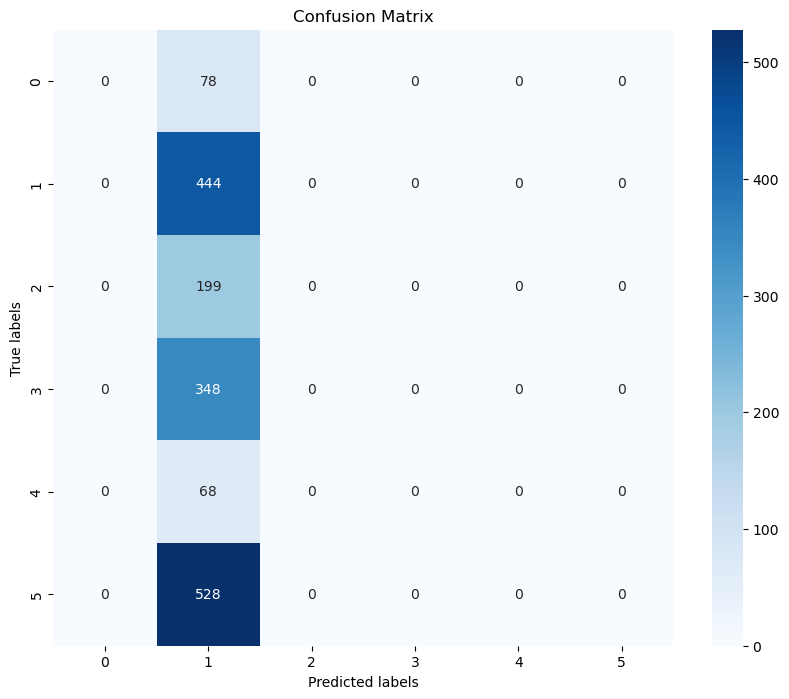

In [ ]:
cm = confusion_matrix(true_labels, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


temporal 120: doesnt work, predict only label 1 and 5

spatial data: doesnt work, predict only label

In [ ]:
name_model = "spatial_600ms_150epochs"
trainer.save_model(f"{data_dir}5_models/{name_model}")

# Archived Codes

In [ ]:
from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
model_id = "state-spaces/mamba-130m-hf"
model = AutoModelForCausalLM.from_pretrained(model_id)
dataset = load_dataset("Abirate/english_quotes", split="train")
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-3
)
lora_config =  LoraConfig(
        r=8,
        target_modules=["x_proj", "embeddings", "in_proj", "out_proj"],
        task_type="CAUSAL_LM",
        bias="none"
)
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    peft_config=lora_config,
    train_dataset=dataset,
    dataset_text_field="quote",
)
trainer.train()

In [ ]:
input_ids = torch.tensor([[101, 102, ...]])  # Example input tensor
outputs = model(input_ids)
print(outputs.logits.shape)  # This should output (1, 6) for your configuration


In [ ]:
test_input = torch.tensor(dataset_dict['train']['input_ids'][1], device=device)

In [ ]:
model = model.to(device)

In [ ]:
device

device(type='cuda')

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Prepare the test input and add a batch dimension if necessary
test_input = torch.tensor(dataset_dict['train']['input_ids'][1], device=device)
if test_input.ndim == 1:
    test_input = test_input.unsqueeze(0)  # Reshape to [1, sequence_length]

# Print the adjusted input shape
print("Adjusted Input Shape:", test_input.shape)

# Try to get the output from the model
try:
    output = model(test_input)
    # Check what keys are in the output dictionary
    print("Output Keys:", output.keys())
    # Access logits if available
    if 'logits' in output:
        print("Logits Shape:", output['logits'].shape)
    else:
        print("Logits key not found in model output.")
except Exception as e:
    print("Error during model evaluation:", e)


Adjusted Input Shape: torch.Size([1, 1800])
Output Keys: dict_keys(['logits'])
Logits Shape: torch.Size([6])


In [ ]:
example_inputs = torch.tensor(tokenized_dataset[500]['input_ids'], device=device)
example_labels = torch.tensor(tokenized_dataset[500]['labels'], device=device)

model.eval()
with torch.no_grad():
    outputs = model(example_inputs.unsqueeze(0))  # Add batch dimension
    logits = outputs['logits']
    print(f"Output logits: {logits}")

# Check outputs
predictions = torch.argmax(logits, dim=-1)
print(f"Predictions: {predictions}")
print(f"Label: {example_labels}")


Output logits: tensor([-0.5986,  1.3730,  0.0273,  0.9082, -0.9707,  1.2109], device='cuda:0')
Predictions: 1
Label: 5


In [ ]:
for i in range(5):
    print(f"Input IDs: {dataset_dict['train'][i]['input_ids']}")
    print(f"Label: {dataset_dict['train'][i]['labels']}")

Input IDs: [0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 112, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 92, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 111, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 97, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 55, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 68, 1, 0, 20, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12, 1, 0, 12,

In [ ]:
for i, data in enumerate(tokenized_dataset):
    print(f"Input IDs Shape: {torch.tensor(data['input_ids']).shape}")  # Expected: [1, 1800] if batch size is 1
    print(f"Labels: {torch.tensor(data['labels'])}")  # Should show only one label per batch
    if i == 5:  # Check only the first batch to avoid flooding the output
        break


Input IDs Shape: torch.Size([1800])
Labels: 0
Input IDs Shape: torch.Size([1800])
Labels: 0
Input IDs Shape: torch.Size([1800])
Labels: 0
Input IDs Shape: torch.Size([1800])
Labels: 0
Input IDs Shape: torch.Size([1800])
Labels: 1
Input IDs Shape: torch.Size([1800])
Labels: 1


In [ ]:
example_inputs

[0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 151,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 22,
 1,
 0,
 20,
 1,
 0,
 12,
 1,
 0,
 56,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 75,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 34,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 4436,
 1,
 0,
 12,
 1,
 0,
 22,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 68,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 75,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 12,
 1,
 0,
 35,
 1,
 0,
 12,
 1,
 0,
 95,
 1,
 0,
 20,
 1,
 0,
 12,
 1,
 0,
 99,
 1,
 0,
 68,
 1,
 0,
 12,


In [ ]:
import torch
from torch.utils.data import DataLoader

# Assuming you have a dataset and a DataLoader set up
subset_loader = DataLoader(dataset, batch_size=10, shuffle=True)  # Small batch size for testing

model.eval()  # Set model to evaluation mode to disable dropout, batch norm, etc.
with torch.no_grad():  # Disable gradient computation
    for batch in subset_loader:
        inputs, labels = batch['input_ids'], batch['labels']
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure data is on the correct device

        outputs = model(inputs)
        logits = outputs['logits']
        predictions = torch.argmax(logits, dim=-1)

        # Check shapes and content
        print("Logits Shape:", logits.shape)
        print("Predictions Shape:", predictions.shape)
        print("Labels Shape:", labels.shape)
        print("First 5 Predictions:", predictions[:5])
        print("First 5 Labels:", labels[:5])

        # Break after first batch to just see one batch of outputs
        break


KeyError: 'input_ids'

In [ ]:
class SPKDataset(Dataset):
    def __init__(self, dataset, label, split='train'):
        self.dataset = dataset
        self.split = split
        self.label = label
        self.label2id = {label: label - 2 for label in range(2, 9)}

    def __getitem__(self, item):
        data = self.dataset[item]
        label = self.label[item]
        mapped_label = self.label2id.get(label, label)
        return data, mapped_label

    def __len__(self):
        return len(self.dataset)

In [ ]:
class SPKNoPadCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        data, labels = zip(*batch)

        # tokenizer without padding and truncation
        inputs = self.tokenizer(list(data), return_tensors='pt')

        # extract input_ids and attention_mask
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        labels_tensor = torch.tensor(labels, dtype=torch.long)

        return input_ids, attention_mask, labels_tensor

In [ ]:
class SPKPadCollator:
    def __init__(self, tokenizer, max_len=512):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __call__(self, batch):
        data, labels = zip(*batch)

        # tokenize WITH padding
        input_ids = []
        attention_mask = []
        for datapoint in data:
            encoded = self.tokenizer.encode(datapoint)
            ids = encoded.ids

            # truncate
            ids = ids[:self.max_len]

            # create attention mask and pad input_ids
            mask = [1] * len(ids)
            num_pad = self.max_len - len(ids)
            ids += [self.tokenizer.token_to_id("[PAD]")] * num_pad
            mask += [0] * num_pad

            input_ids.append(ids)
            attention_mask.append(mask)

        # convert to tensors
        input_ids_tensor = torch.tensor(input_ids, dtype=torch.long)
        attention_mask_tensor = torch.tensor(attention_mask, dtype=torch.long)
        labels_tensor = torch.tensor(labels, dtype=torch.long)

        return input_ids_tensor, attention_mask_tensor, labels_tensor


In [ ]:
def create_dataloader(data, labels, tokenizer, batch_size=64, shuffle=True, max_len=512):
    dataset = SPKDataset(data, labels)
    collator = SPKCollator(tokenizer, max_len=max_len)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collator, num_workers=0)
    return dataloader

In [ ]:
train_loader = create_dataloader(X_train, y_train, wrapped_tokenizer, batch_size=16, shuffle=True, max_len=512)
val_loader = create_dataloader(X_val, y_val, wrapped_tokenizer, batch_size=16, shuffle=False, max_len=512)
test_loader = create_dataloader(X_test, y_test, wrapped_tokenizer, batch_size=16, shuffle=False, max_len=512)

In [ ]:
class_weights_tensor = torch.tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
def train(model, loader, optimizer, mode='train'):
  if mode == 'train':
    model.train()
  else:
    model.eval()

  device = torch.device('cuda')
  amp = True
  scalar = torch.cuda.amp.GradScaler(enabled=amp)
  model.to(device)

  all_predictions = []
  all_labels = []

  for _, (input_ids, attention_mask, aligned_labels) in enumerate(loader):
    input_ids, attention_mask, aligned_labels = input_ids.to(device), attention_mask.to(device), aligned_labels.to(device)

    # use fp16 to speed up
    with torch.cuda.amp.autocast(enabled=amp):

      # feed the input to the model
      outputs = model(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device), labels=aligned_labels.to(device))

      # compute the loss
      loss = outputs.loss
      # loss = loss_fn(outputs.logits, aligned_labels.to(torch.float32)) # with weighted loss
      # loss = loss_fn(outputs.logits, aligned_labels.to(torch.float32)) # with weighted loss

      # store the predictions and labels

      cur_predictions = outputs.logits.argmax(dim=-1).data.cpu().numpy().tolist()
      cur_labels = aligned_labels.data.cpu().numpy().tolist()

      # Check if cur_predictions is a list of lists or a list of ints
      if all(isinstance(item, list) for item in cur_predictions):
        # flatten cur_predictions and cur_labels if they are lists of lists
        cur_predictions = [item for sublist in cur_predictions for item in sublist]
        cur_labels = [item for sublist in cur_labels for item in sublist]

      all_predictions.extend(cur_predictions)
      all_labels.extend(cur_labels)

    # print('{} step {} loss: {}'.format(mode, idx, loss.data.cpu().numpy()))
    if mode == 'train':
      # update the model parameters
      optimizer.zero_grad()
      if scalar is not None:
        scalar.scale(loss).backward()
        scalar.step(optimizer)
        scalar.update()
      else:
        loss.backward()
        optimizer.step()
  return all_predictions, all_labels

#optim = torch.optim.Adam(model.parameters(), lr=1e-5)
#predictions, labels = train(model, train_1k_loader, optim, mode='train')
#true_labels, true_predictions = postprocess(predictions, labels)
#print()

In [ ]:
def obtain_performance(model, train_loader, val_loader, optim):
  best_val_micro_f1 = 0
  best_val_macro_f1 = 0
  best_val_macro_epoch = 0
  best_val_micro_epoch = 0
  for epoch in range(10):
    print('===================== Epoch {} ===================='.format(epoch))
    train_predictions, train_labels = train(model, train_loader, optim, mode='train')
    val_predictions, val_labels = train(model, val_loader, optim, mode='eval')
    # train_true_labels, train_true_predictions = postprocess(train_predictions, train_labels)
    # val_true_labels, val_true_predictions = postprocess(val_predictions, val_labels)
    train_true_labels = train_labels
    train_true_predictions = train_predictions
    val_true_labels = val_labels
    val_true_predictions = val_predictions
    # micro f1
    train_f1 = f1_score(train_true_labels, train_true_predictions, average='micro')
    val_f1 = f1_score(val_true_labels, val_true_predictions, average='micro')
    print('Micro Train F1: {}, Val F1: {}'.format(train_f1, val_f1))
    if val_f1 > best_val_micro_f1:
      best_val_micro_f1 = val_f1
      best_val_micro_epoch = epoch
    # macro f1
    train_f1 = f1_score(train_true_labels, train_true_predictions, average='macro')
    val_f1 = f1_score(val_true_labels, val_true_predictions, average='macro')
    # per class f1
    train_f1s = f1_score(train_true_labels, train_true_predictions, average=None)
    val_f1s = f1_score(val_true_labels, val_true_predictions, average=None)
    print('Per class Train F1s: {}, Val F1s: {}'.format(train_f1s, val_f1s))
    print('Macro Train F1: {}, Val F1: {}'.format(train_f1, val_f1))
    if val_f1 > best_val_macro_f1:
      best_val_macro_f1 = val_f1
      best_val_macro_epoch = epoch
  print('Best Val Micro F1: {}, Best Val Macro F1: {}'.format(best_val_micro_f1, best_val_macro_f1))
  print('Best Val Micro Epoch: {}, Best Val Macro Epoch: {}'.format(best_val_micro_epoch, best_val_macro_epoch))

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(class_weights))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
obtain_performance(model, train_loader, val_loader, optim)

===================== Epoch 0 ====================
Micro Train F1: 0.28793903247183567, Val F1: 0.28488596830305374
Per class Train F1s: [0.00970874 0.34262199 0.         0.10957255 0.00453515 0.37691596
 0.        ], Val F1s: [0.         0.44344164 0.         0.         0.         0.
 0.        ]
Macro Train F1: 0.12047919630429801, Val F1: 0.06334880522606154
===================== Epoch 1 ====================
Micro Train F1: 0.28180914512922467, Val F1: 0.29918824893699264
Per class Train F1s: [0.         0.32688844 0.         0.08872902 0.         0.37985352
 0.        ], Val F1s: [0.         0.         0.         0.         0.         0.46057721
 0.        ]
Macro Train F1: 0.11363870980030381, Val F1: 0.06579674416627704
===================== Epoch 2 ====================
Micro Train F1: 0.29042412193505635, Val F1: 0.28488596830305374
Per class Train F1s: [0.         0.34052701 0.         0.0771725  0.         0.38559197
 0.        ], Val F1s: [0.         0.44344164 0.         0. 

In [ ]:
torch.save(model.state_dict(), 'trained_model.pt')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.eval()


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(

    "distilbert/distilbert-base-uncased", num_labels=2,

)

config.json: 100%|██████████| 483/483 [00:00<00:00, 3.52MB/s]
model.safetensors: 100%|██████████| 268M/268M [00:02<00:00, 104MB/s]  
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
test = model([3]*5000)

TypeError: list indices must be integers or slices, not tuple

In [ ]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")

In [ ]:
from transformers import RwkvConfig, RwkvModel
import torch
inputs = {'input_ids':
          torch.tensor([[1]*6000]).to('cuda'),
          'attention_mask': torch.tensor([[1]*6000]).to('cuda')}


# Initializing a Rwkv configuration

configuration = RwkvConfig(context_length=6000)

# Initializing a model (with random weights) from the configuration

model = RwkvModel(configuration)

# Accessing the model configuration

configuration = model.config



/home/zubat/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 